In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import ast
import arabic_reshaper
from bidi.algorithm import get_display

from wordcloud import WordCloud
from scipy.interpolate import make_interp_spline

%matplotlib inline

In [2]:
speeches = pd.read_csv("../data/cleaned_speeches.csv", sep='\t', index_col=0)

In [3]:
speeches.tail()

,year,speaker,speech,n_words
443,1394,موحدی,"['خطيب', 'موقت', 'نماز', 'جمعه', 'تهران', 'بيا...",1266
444,1394,صدیقی,"['خطيب', 'نماز', 'جمعه', 'تهران', 'تصريح', 'کر...",1341
445,1394,صدیقی,"['خطيب', 'نماز', 'جمعه', 'هفته', 'تهران', 'گفت...",1630
446,1394,جنتی,"['آيت', 'الله', 'احمد', 'جنتي', 'گفت:', 'برجام...",1256
447,1394,موحدی,"['آيت', 'الله', 'موحدي', 'کرماني', 'تأکيد', 'ا...",1050


In [6]:
def count_tokens(speech):
    count_dict = {}
    for w in speech:
        count_dict[w] = count_dict.get(w, 0) + 1
    return count_dict

In [7]:
def find_top_k(speech, k=1000):
    ''' Get top k words '''
    count_dict = count_tokens(speech)
    count_tuples = [(key, value) for key, value in count_dict.items()]
    sorted_tuples = sorted(count_tuples, key=lambda tup: tup[1], reverse=True)
    top_k_tuples = sorted_tuples[0:k]
    top_k_tokens = [key for key, _ in top_k_tuples]
    
    return top_k_tokens

In [8]:
def find_tf(speech):
    '''
    This function finds the augmented frequency of a token
    Input: list of tokens
    Returns: A dictionary containing the TF value for each token
    '''
    if not speech:
        return {}
    count_dict = count_tokens(speech)
    top_token = find_top_k(speech, 1)

    # Find the largest frequency of among the tokens in the list
    top_freq = count_dict.get(top_token[0])
    
    tf_dict = {}
    # Iterate over the tokens and calculate the TF value for each using
    # the given formula in the instructions. Then, add each token and its
    # TF value to tf_dict dictionary
    for token, count in count_dict.items():
        tf = 0.5 + 0.5 * count / top_freq
        tf_dict[token] = tf

    return tf_dict

In [9]:
list_of_speeches = []
for row_i in range(len(speeches)):
    speech = ast.literal_eval(speeches.at[row_i, 'speech'])
    year = speeches.at[row_i, 'year']
    list_of_speeches.append((speech, year))

In [10]:
def find_idf():
    '''
    Find the inverse document frequency of all tokens in the documents
    '''
    num_of_speeches = len(list_of_speeches)

    idf_dict = {}
    for speech, _ in list_of_speeches:
        for w in speech:
            if w in idf_dict.keys():
                continue
            
            counter = 0
            for sp, _ in list_of_speeches:
                if w in sp:
                    counter += 1
            idf_dict[w] = math.log(num_of_speeches / counter)

    return idf_dict

In [11]:
idf_dict = find_idf()

In [12]:
def find_salient(threshold):
    '''
    Compute the salient words for each document.  A word is salient if
    its tf-idf score is strictly above a given threshold.

    Returns: list of sets of salient words
    '''
    tf_dicts = [find_tf(sp) for sp,_ in list_of_speeches]
    #idf_dict = find_idf()

    salient_sets = []
    for index, sp in enumerate(list_of_speeches):
        speech, year = sp
        salient = set()
        for w in speech:
            tf_idf = tf_dicts[index].get(w) * idf_dict.get(w)
            if tf_idf > threshold:
                salient.add(w)
        salient_sets.append((salient, year))

    return salient_sets

In [13]:
salient_words = find_salient(2)

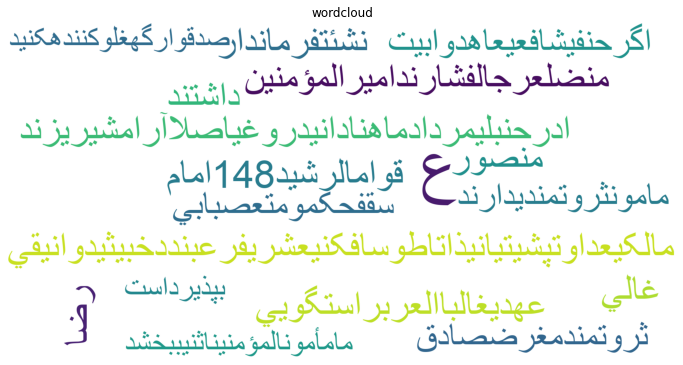

In [15]:
fig = plt.gcf()
fig.set_size_inches(12, 8)
data = arabic_reshaper.reshape("".join(salient_words[300][0]))
data = get_display(data) # add this line
wd = WordCloud(font_path='Arial.ttf', background_color='white',
                  mode='RGB', width=2000, height=1000).generate(data)
plt.title("wordcloud")
plt.imshow(wd)
plt.axis("off")
plt.show()

In [19]:
YEARS = list(range(1378, 1381)) + list(range(1392, 1399)) + [1400]

In [20]:
def annual_freq(word):
    freqs = []
    for year in YEARS:
        counter = 0
        for sp, y in salient_words:
            if year == y:
                for w in sp:
                    if word in w:
                        counter += 1
        freqs.append(counter)
    
    return freqs